In [1]:
import pandas as pd
import pickle
import datetime
import logging
from sklearn.model_selection import train_test_split

In [2]:
import sys
sys.path.insert(0, './utils/')

import sklearn_pipeline_customized as spc
import feature_selection as fs
import classification_models as cm

In [3]:
import importlib
importlib.reload(spc)

<module 'sklearn_pipeline_customized' from 'E:\\github\\lending_club\\lending_club_loans_default_prediction\\./utils\\sklearn_pipeline_customized.py'>

In [4]:
data_path = './data/loan.csv'

df = pd.read_csv(data_path)

C:\Users\xzhou\AppData\Local\Temp\ipykernel_28844\1420088683.py:3: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [5]:
# Assign labels based on loan status

excluded = {'Issued', 'Does not meet the credit policy. Status:Charged Off',
            'Does not meet the credit policy. Status:Fully Paid'}
positive = {'Current', 'Fully Paid'}
negative = {'Charged Off', 'Default', 'In Grace Period', 
       'Late (16-30 days)', 'Late (31-120 days)'}

def assign_label(status):
    """
    Classify loan staus based on description
    """
    try: 
        status=status.strip()
        if status in positive:
            return "positive"
        elif status in negative:
            return "negative"
        else: 
            return "excluded"
    except: 
        return "excluded"

In [6]:
df['label'] = df['loan_status'].apply(lambda x: assign_label(x))

In [7]:
# Drop ids, and loan status to prevent info leakage
cols_to_drop = ['id', 'member_id', 'loan_status']
df_id_removal = df.drop(columns = cols_to_drop)

In [8]:
# Only keep loans with good or bad status
df_label = df_id_removal[df_id_removal['label']!='excluded']
df_label.label.unique()

array(['positive', 'negative'], dtype=object)

In [9]:
X = df_label.drop('label', axis=1)
y = df_label['label']

In [10]:
X.shape

(876170, 71)

In [11]:
# Get the column names
date_columns = [col for col in X.columns if 'date' in col.lower()]
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

In [13]:
pipeline = spc.preprocessing_pipeline(date_columns=date_columns,
                                      numerical_columns=numerical_columns, 
                                      categorical_columns=categorical_columns)

In [14]:
X_processed = pipeline.fit_transform(X)

INFO:root:Entered Numerical Columns: ExtremeValuesNumericalHandler
INFO:root:Entered Categorical Columns: DummyVariableCreator


In [15]:
y, unique_labels = pd.factorize(y)
label_encoding = {label: idx for idx, label in enumerate(unique_labels)}

label_encoding

{'positive': 0, 'negative': 1}

In [16]:
feature_names = pipeline.get_feature_names_out()

# Clean up feature names for xbgoost
feature_names = [x.replace('[', '_replace_bracket_open_')\
                 .replace(']', '_replace_bracket_close_')\
                 .replace('<', '_smaller_than_') for x in feature_names]

In [17]:
data = pd.concat([pd.DataFrame(X_processed, columns=feature_names).reset_index(drop=True), 
                  pd.DataFrame(y, columns = ['label']).reset_index(drop=True)], 
                  axis=1)

In [18]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

X_train = train_data.drop(columns = ['label'])
y_train = train_data['label']
X_test = test_data.drop(columns = ['label'])
y_test = test_data['label']

INFO:root:Starting feature selection...


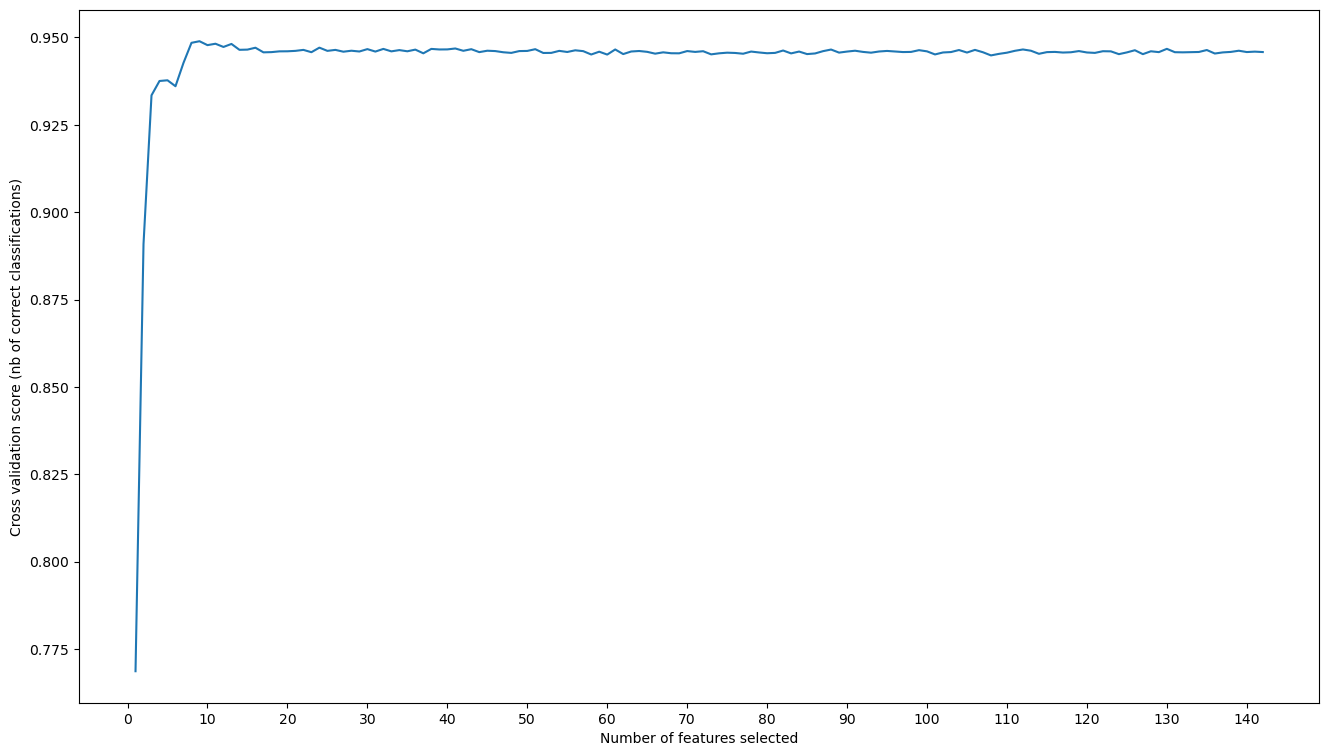

INFO:root:Feature selection completed in 1041.00 seconds
INFO:root:Number of features selected: 9
INFO:root:Selected features : ['num__int_rate', 'num__installment', 'num__dti', 'num__revol_bal', 'num__revol_util', 'num__out_prncp', 'num__total_rec_prncp', 'num__total_rec_int', 'num__last_pymnt_amnt']


In [23]:
selected_features = fs.select_features(X_train, y_train, n_samples=50000) 

C:\Users\xzhou\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Logistic Regression: Done (Execution Time: 0.07 seconds)
KNN: Done (Execution Time: 0.14 seconds)
SVM: Done (Execution Time: 435.19 seconds)
Random Forest: Done (Execution Time: 21.32 seconds)
XGBoost: Done (Execution Time: 6.31 seconds)


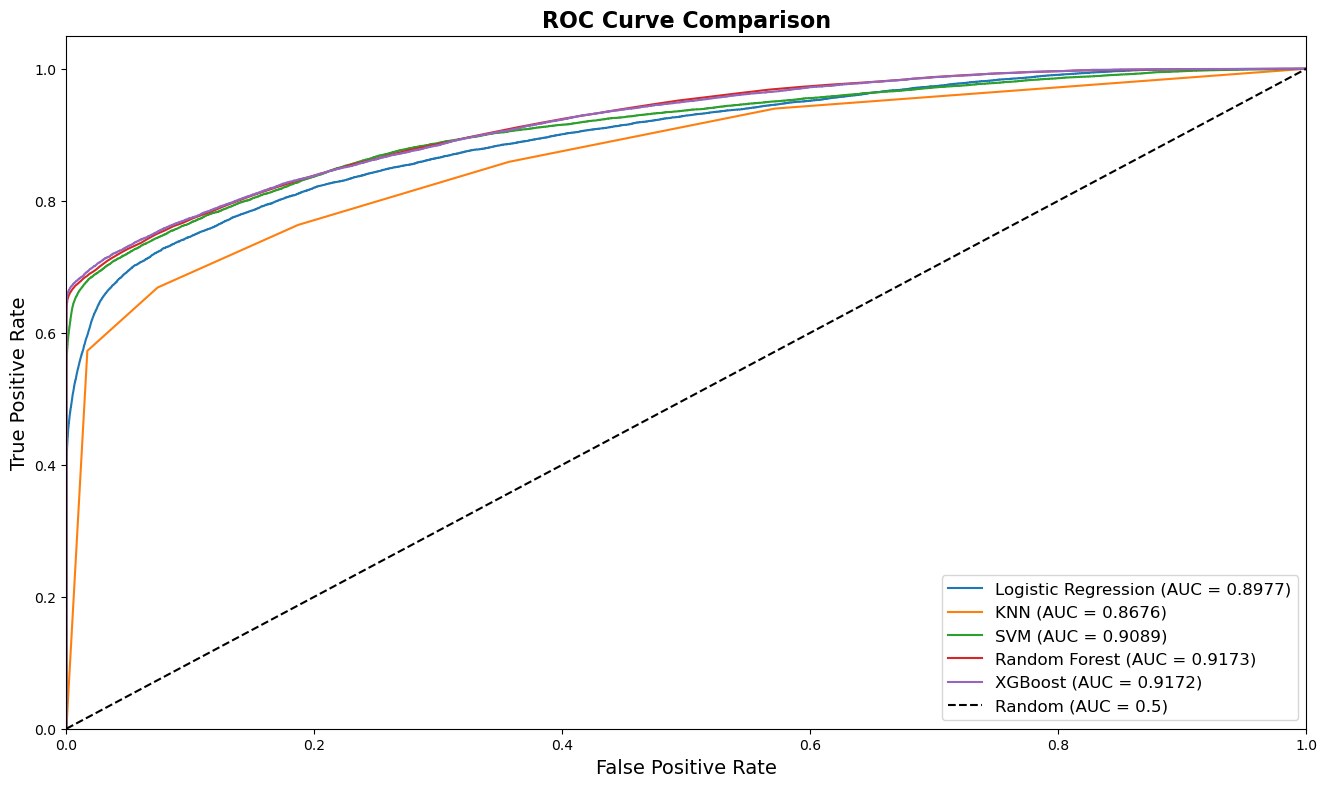

Model Performance Metrics:

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.875389   0.353858  0.757183  0.482314  0.897659
1                  KNN  0.809440   0.253386  0.763238  0.380462  0.867597
2                  SVM  0.939726   0.588315  0.712074  0.644305  0.908938
3        Random Forest  0.944147   0.617523  0.713166  0.661907  0.917259
4              XGBoost  0.956253   0.720849  0.700710  0.710637  0.917210

Best Performing Model:

Model         XGBoost
Accuracy     0.956253
Precision    0.720849
Recall        0.70071
F1 Score     0.710637
ROC AUC       0.91721
Name: 4, dtype: object

Best Performing Model:

Model        Random Forest
Accuracy          0.944147
Precision         0.617523
Recall            0.713166
F1 Score          0.661907
ROC AUC           0.917259
Name: 3, dtype: object

Saved best model (Random Forest) to a pickle file.


In [24]:
best_model = cm.run_classification_models(X_train=X_train[selected_features], 
                                          y_train=y_train, 
                                          X_test=X_test[selected_features], 
                                          y_test=y_test, 
                                          n_samples=50000, 
                                          scoring_metric='f1 score')

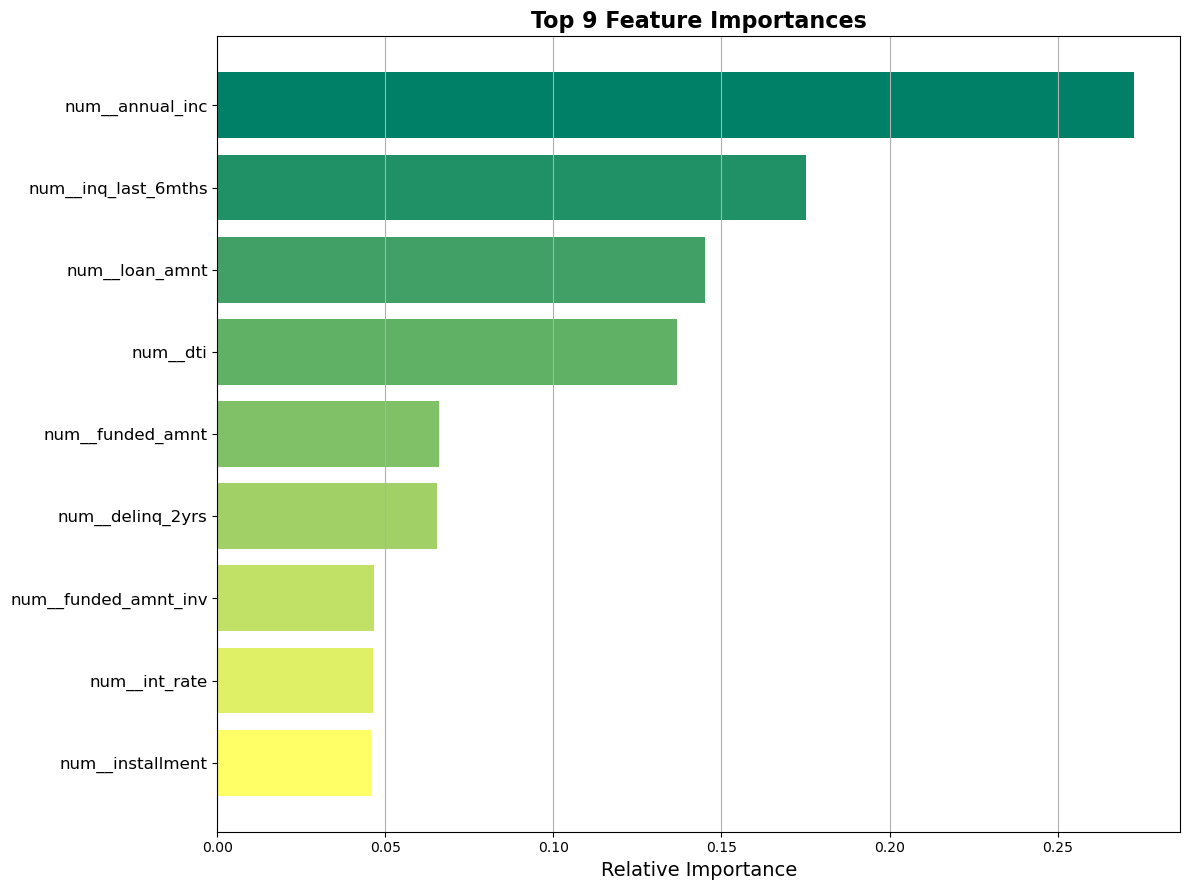

{'num__annual_inc': 0.2727941039957901,
 'num__inq_last_6mths': 0.1751869143136272,
 'num__loan_amnt': 0.1450598330390732,
 'num__dti': 0.1368700551525247,
 'num__funded_amnt': 0.06593727351363757,
 'num__delinq_2yrs': 0.06545377760969125,
 'num__funded_amnt_inv': 0.04664187135899339,
 'num__int_rate': 0.04634502056142274,
 'num__installment': 0.045711150455239886}

In [26]:
cm.plot_top_n_features(best_model, 
                       feature_names = X_train.columns,
                       selected_features = selected_features)